In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# --- 1. MOUNTING & PATH CONFIGURATION ---
def log_audit(message):
    print(f"[AUDIT LOG] {message}")

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # Using the verified path from your Drive screenshots
    BASE_PATH = '/content/drive/MyDrive/Capstone/'
    log_audit("Drive mounted successfully.")
except Exception as e:
    BASE_PATH = './'
    log_audit(f"Mounting failed or running locally: {e}")

INPUT_PATH = os.path.join(BASE_PATH, 'selected_features.csv')
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'best_xgb_model.pkl')
ENCODER_SAVE_PATH = os.path.join(BASE_PATH, 'target_encoder.pkl')

Mounted at /content/drive
[AUDIT LOG] Drive mounted successfully.


In [3]:
# --- 2. DATA LOADING & PREPARATION ---
log_audit("Loading feature-selected dataset...")
df = pd.read_csv(INPUT_PATH)

# Target Encoding: P1, P2, P3, P4 -> 0, 1, 2, 3
target_le = LabelEncoder()
df['Approved_Flag'] = target_le.fit_transform(df['Approved_Flag'])
log_audit(f"Target classes encoded: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}")

# One-Hot Encoding for remaining categorical features
# Note: This handles MARITALSTATUS, EDUCATION, etc., identified in Notebook 3
df_final = pd.get_dummies(df, drop_first=True)

X = df_final.drop('Approved_Flag', axis=1)
y = df_final['Approved_Flag']

# Stratified split ensures risk grade proportions are maintained
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

[AUDIT LOG] Loading feature-selected dataset...
[AUDIT LOG] Target classes encoded: {'P1': np.int64(0), 'P2': np.int64(1), 'P3': np.int64(2), 'P4': np.int64(3)}


In [4]:
# --- 3. HYPERPARAMETER TUNING (GRID SEARCH) ---
log_audit("Starting GridSearchCV for XGBoost...")

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.8]
}

# multi:softmax is used for multi-class classification (P1-P4)
xgb = XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

log_audit(f"Best Parameters Found: {grid_search.best_params_}")

[AUDIT LOG] Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[AUDIT LOG] Best Parameters Found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [5]:
# --- 4. EVALUATION ---
log_audit("Generating Performance Metrics...")
y_pred = best_model.predict(X_test)

# Report includes Precision, Recall, and F1-Score for each Risk Grade
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

[AUDIT LOG] Generating Performance Metrics...

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

          P1       0.81      0.78      0.80      1161
          P2       0.84      0.93      0.88      6440
          P3       0.48      0.26      0.34      1491
          P4       0.78      0.75      0.77      1176

    accuracy                           0.80     10268
   macro avg       0.73      0.68      0.70     10268
weighted avg       0.78      0.80      0.78     10268



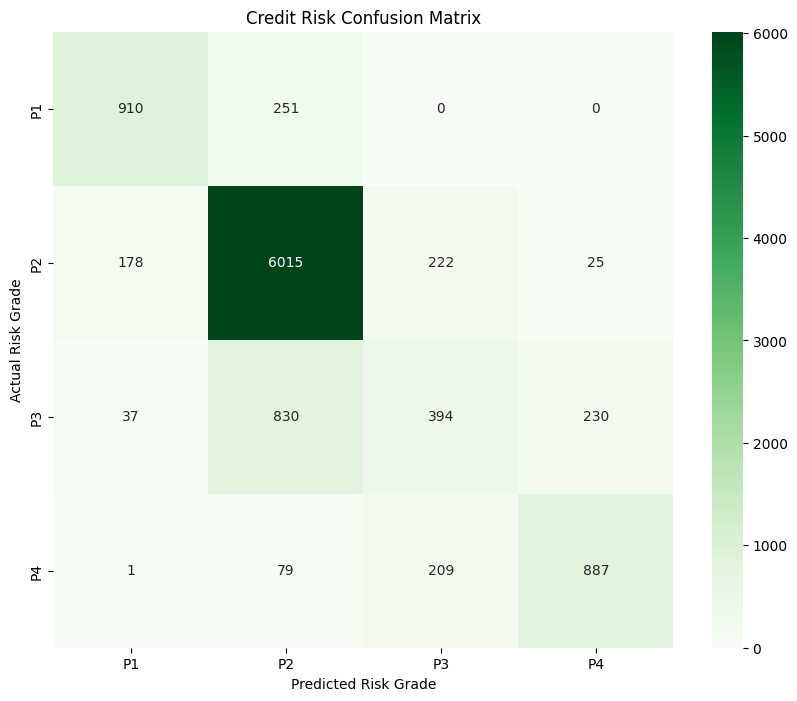

In [6]:
# Confusion Matrix: Critical for identifying misclassified 'High Risk' cases
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.title('Credit Risk Confusion Matrix')
plt.ylabel('Actual Risk Grade')
plt.xlabel('Predicted Risk Grade')
plt.show()

In [7]:
# --- 5. PERSISTENCE ---
joblib.dump(best_model, MODEL_SAVE_PATH)
joblib.dump(target_le, ENCODER_SAVE_PATH)
log_audit(f"Model and Encoder saved to {BASE_PATH}. Ready for Notebook 5.")

[AUDIT LOG] Model and Encoder saved to /content/drive/MyDrive/Capstone/. Ready for Notebook 5.
